# Import dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import tensorflow as tf

from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense

# Prepare the data

In [2]:
data = pd.read_csv("../collected_data/prepared_data/pre_and_post_step_data.csv")
data_diff = pd.read_csv("../collected_data/prepared_data/diff_step_data.csv")

array([[<AxesSubplot: title={'center': 'steps_time'}>,
        <AxesSubplot: title={'center': 'vertices_pre'}>,
        <AxesSubplot: title={'center': 'redexes_pre'}>],
       [<AxesSubplot: title={'center': 'heights_pre'}>,
        <AxesSubplot: title={'center': 'widths_pre'}>,
        <AxesSubplot: title={'center': 'vertices_post'}>],
       [<AxesSubplot: title={'center': 'redexes_post'}>,
        <AxesSubplot: title={'center': 'heights_post'}>,
        <AxesSubplot: title={'center': 'widths_post'}>],
       [<AxesSubplot: title={'center': 'redex_depths'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

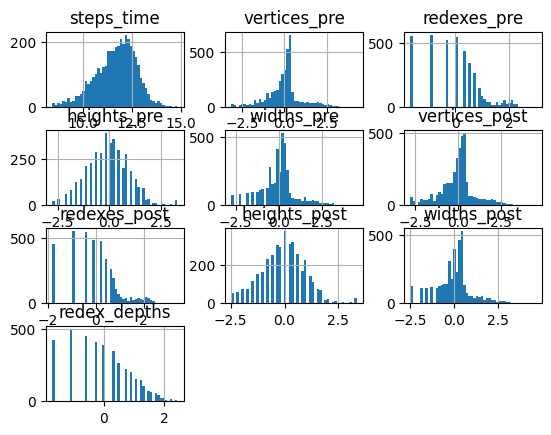

In [3]:
power_trans = PowerTransformer(method='yeo-johnson')

data_norm = pd.DataFrame()
for col_name in ['steps_time']:
    norm_col_data = np.log(data[col_name])
    data_norm[col_name] = norm_col_data

for col_name in ['vertices_pre', 'redexes_pre', 'heights_pre', 'widths_pre',
                 'vertices_post', 'redexes_post', 'heights_post', 'widths_post', 'redex_depths']:
    norm_col_data = power_trans.fit_transform(np.array(data[col_name]).reshape(-1, 1))
    data_norm[col_name] = list(norm_col_data.reshape(1, -1))[0]

data_norm.hist(bins=50)

In [4]:
data_for_training = data_norm.copy(deep=True)

In [5]:
for col_name in ['vertices_dif', 'redexes_dif', 'heights_dif', 'widths_dif']:
    norm_col_data = np.array(np.abs(data_diff[col_name]))
    norm_col_data = power_trans.fit_transform(norm_col_data.reshape(-1, 1))
    data_for_training[col_name] = list(norm_col_data.reshape(1, -1)[0])

In [6]:
def split_dataset(dataset, test_ratio=0.3):
    test_indices_filter = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices_filter], dataset[test_indices_filter]


train_ds, test_ds = split_dataset(data_for_training)
print(f"Examples for training {len(train_ds)}")
print(f"Examples for testing {len(test_ds)}")

Examples for training 2661
Examples for testing 1270


In [7]:
x_train, y_train = train_ds.drop("steps_time", axis=1), train_ds[["steps_time"]]
x_test, y_test = test_ds.drop("steps_time", axis=1), test_ds[["steps_time"]]
x_data, y_data = data_for_training.drop("steps_time", axis=1), data_for_training[["steps_time"]]

# Train the Linear Regression

In [8]:
rcParams['figure.figsize'] = 10, 9


def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Step Time")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

TRAIN Root Mean Squared Error(RMSE): 0.28936025330324383
TEST Root Mean Squared Error(RMSE): 0.3039515843541706


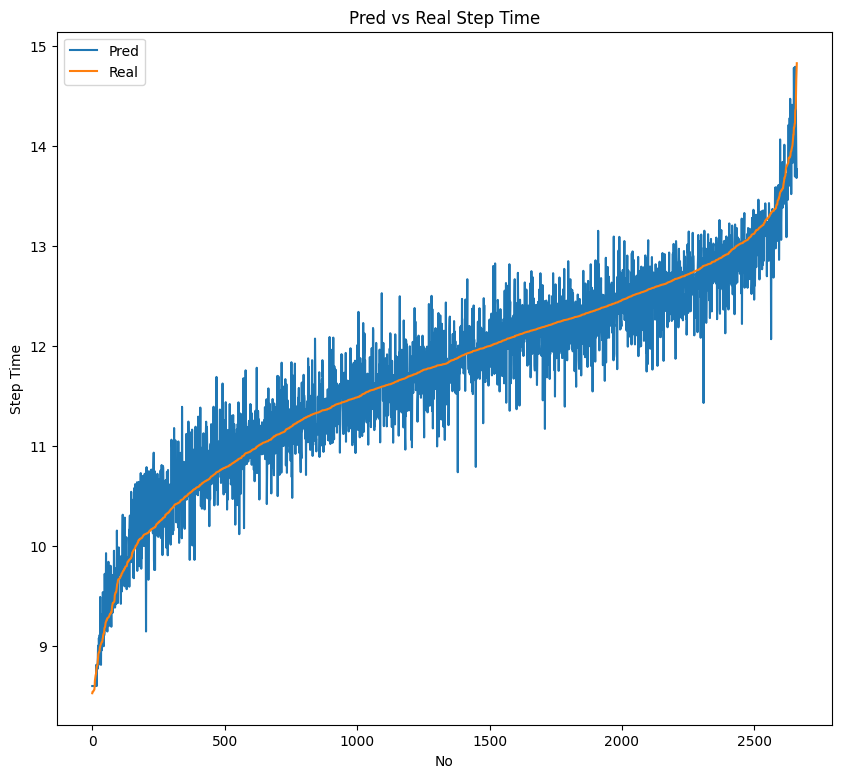

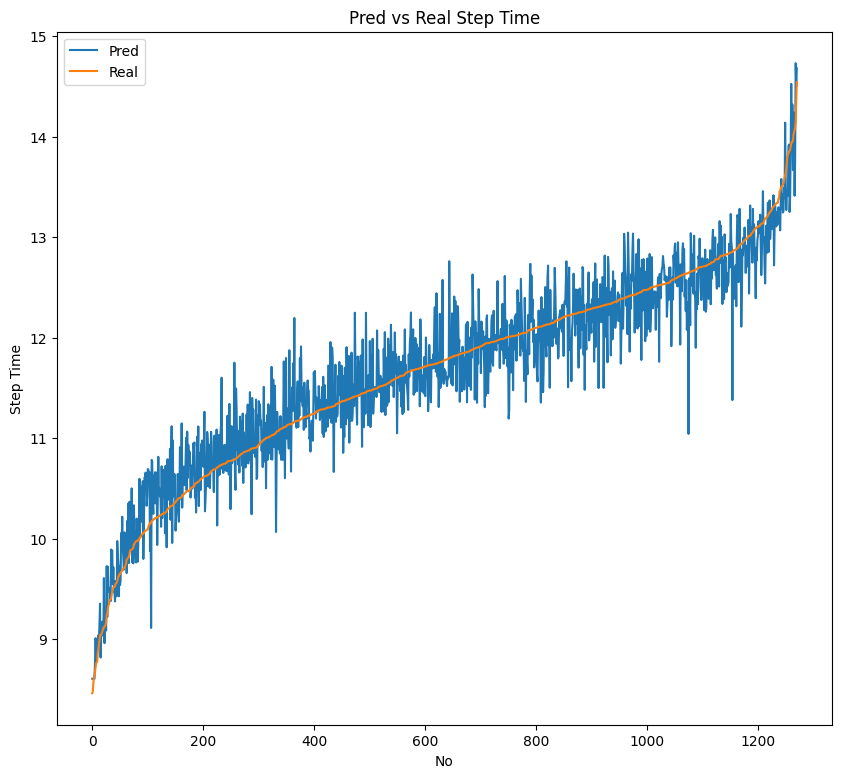

In [9]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_train, y_train)

y_train_pred = lin_regressor.predict(x_train)
y_test_pred = lin_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [10]:
mse_train = mean_squared_error(y_train["steps_time"].to_list(), list(y_train_pred[:, -1]))
print("Train {Mean Squared Error}:", mse_train)

mse_test = mean_squared_error(y_test["steps_time"].to_list(), list(y_test_pred[:, -1]))
print("Test {Mean Squared Error}:", mse_test)
mae_train = mean_absolute_error(y_train["steps_time"].to_list(), list(y_train_pred[:, -1]))
print("Train {Mean Absolute Error}:", mae_train)

mae_test = mean_absolute_error(y_test["steps_time"].to_list(), list(y_test_pred[:, -1]))
print("Test {Mean Absolute Error}:", mae_test)


def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true_fix = np.array([y_ for y_ in y_true])
    percentage_errors = np.abs((y_true - y_pred) / y_true_fix) * 100
    mape = np.mean(percentage_errors)
    return mape


mape_train = mean_absolute_percentage_error(y_train["steps_time"].to_list(), list(y_train_pred[:, -1]))
print("Train {Mean Absolute Percentage Error}:", mape_train)

mape_test = mean_absolute_percentage_error(y_test["steps_time"].to_list(), list(y_test_pred[:, -1]))
print("Test {Mean Absolute Percentage Error}:", mape_test)

Train {Mean Squared Error}: 0.08372935619171742
Test {Mean Squared Error}: 0.09238656563141048
Train {Mean Absolute Error}: 0.2244058419551268
Test {Mean Absolute Error}: 0.23700560322033262
Train {Mean Absolute Percentage Error}: 1.9306395978902964
Test {Mean Absolute Percentage Error}: 2.047948333682174


ALL RMSE: 0.29390480854447604


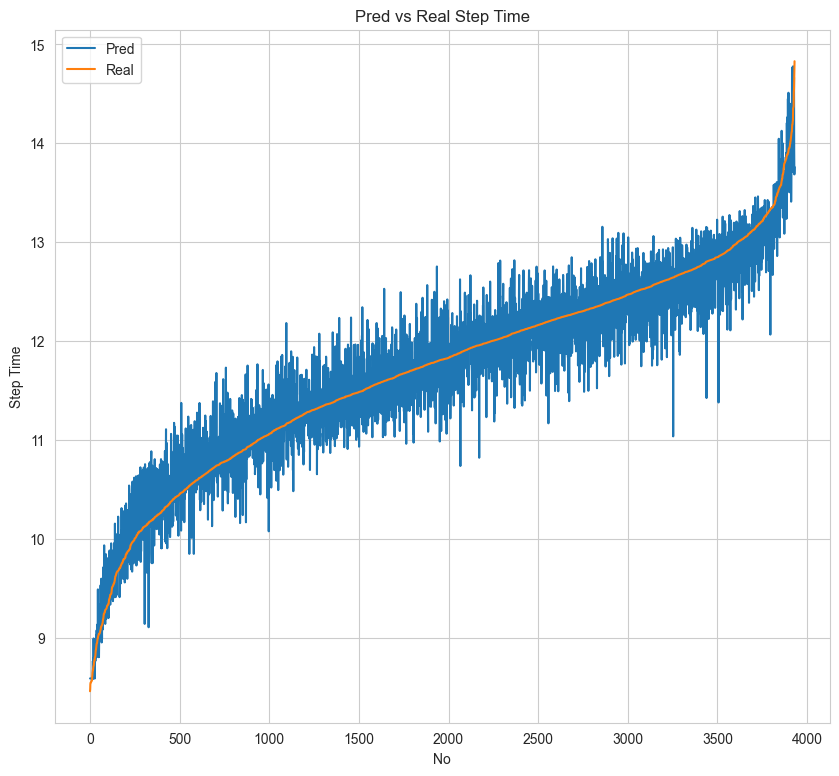

In [10]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_data, y_data)

y_data_pred = lin_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_data_pred[:, -1]), y_data["steps_time"].to_list())

# Train the ANN Regression

In [11]:
model = Sequential()
model.add(Dense(units=30, activation='relu', input_dim=13))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=1)

Epoch 1/20
2767/2767 [==============================] - 4s 1ms/step - loss: 18.1679 - val_loss: 1.7334
Epoch 2/20
2767/2767 [==============================] - 3s 1ms/step - loss: 0.7904 - val_loss: 0.4654
Epoch 3/20
2767/2767 [==============================] - 4s 1ms/step - loss: 0.2707 - val_loss: 0.1686
Epoch 4/20
2767/2767 [==============================] - 3s 1ms/step - loss: 0.1413 - val_loss: 0.1232
Epoch 5/20
2767/2767 [==============================] - 4s 1ms/step - loss: 0.1220 - val_loss: 0.1175
Epoch 6/20
2767/2767 [==============================] - 4s 1ms/step - loss: 0.1157 - val_loss: 0.0863
Epoch 7/20
2767/2767 [==============================] - 3s 1ms/step - loss: 0.1118 - val_loss: 0.0934
Epoch 8/20
2767/2767 [==============================] - 4s 1ms/step - loss: 0.1057 - val_loss: 0.0964
Epoch 9/20
2767/2767 [==============================] - 3s 1ms/step - loss: 0.1042 - val_loss: 0.0857
Epoch 10/20
2767/2767 [==============================] - 4s 2ms/step - loss: 0.10

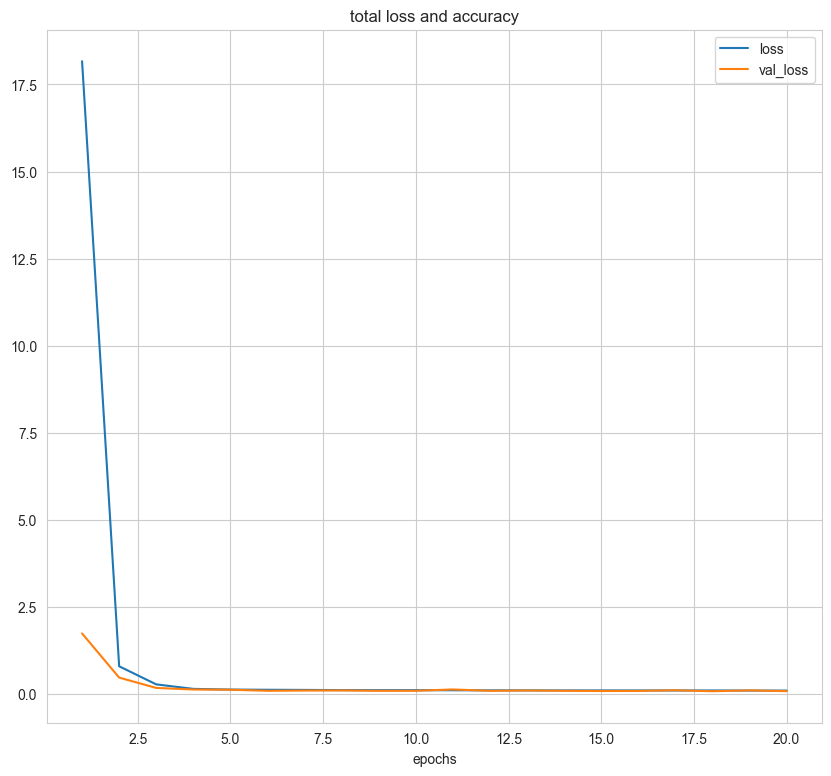

In [12]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label="val_loss")
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

In [11]:
# load the model
with open("./models/ann_30_1_pre_post_diff/structure.json", "r") as file:
    loaded_model_json = file.read()

model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights("./models/ann_30_1_pre_post_diff/weights.h5")

In [12]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

123/123 [==============================] - 0s 759us/step


TRAIN Root Mean Squared Error(RMSE): 0.27684089872450474
TEST Root Mean Squared Error(RMSE): 0.28040414889119863
ALL RMSE: 0.2779970838242548


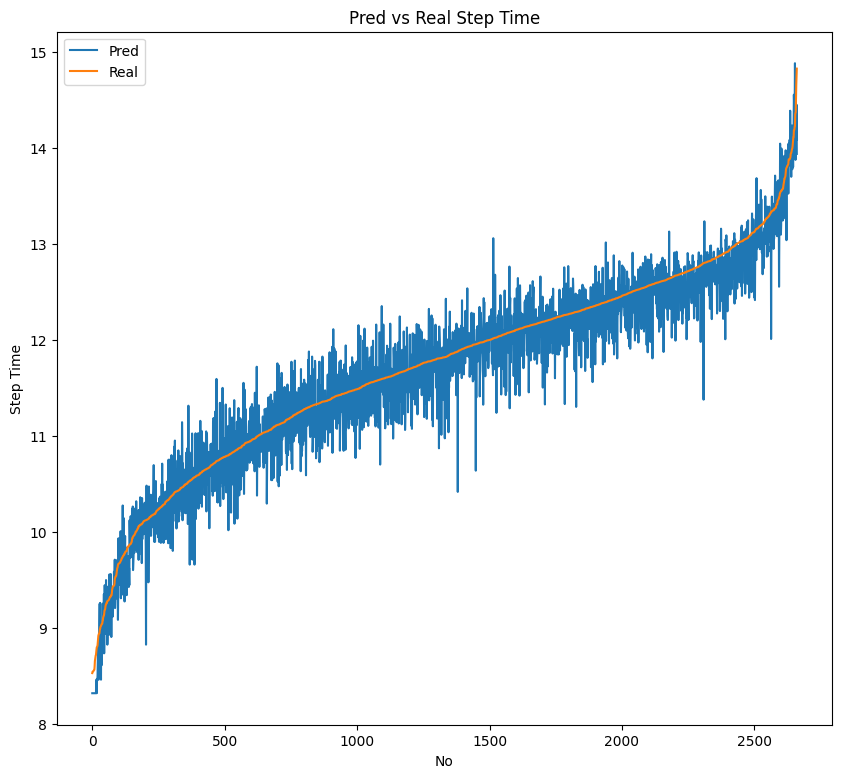

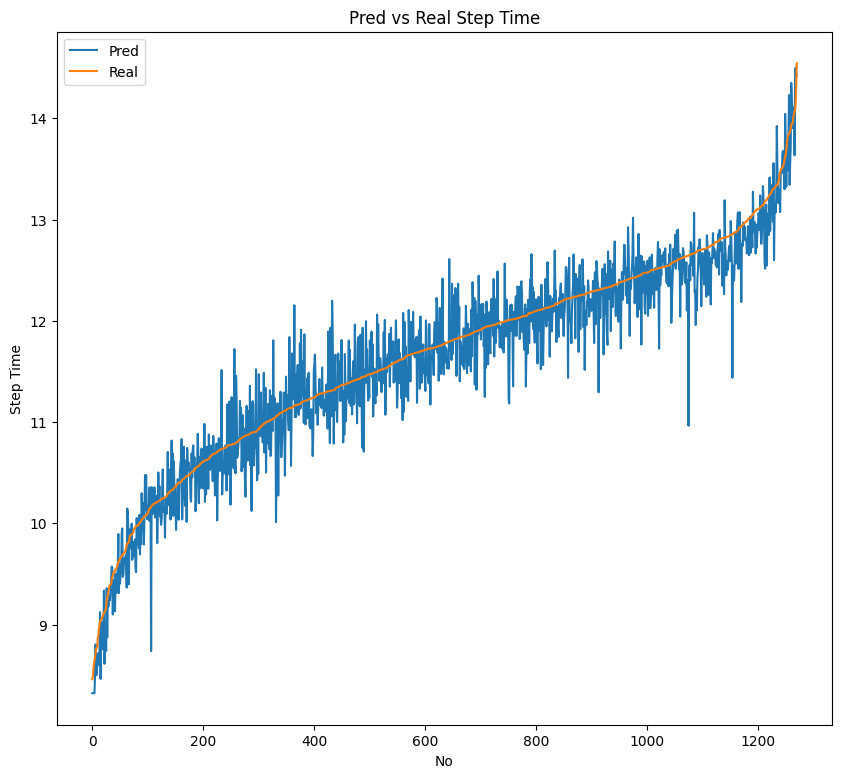

In [13]:
print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

# Save the Model

In [15]:
model_structure = model.to_json()
with open("./models/ann_30_1_pre_post_diff/structure.json", 'w') as json_file:
    json_file.write(model_structure)

model.save_weights("./models/ann_30_1_pre_post_diff/weights.h5")

# Additional metrics & plots

In [14]:
def draw_pred_scatter(y_pred, y_real):
    plt.scatter(y_real, y_pred, s=3)
    plt.plot([8.5, 15], [8.5, 15], color='gray', linestyle='--')

    plt.xlabel("Real reduction time")
    plt.ylabel("Predicted time")
    plt.title("Pred vs Real Reduction time")
    plt.show()

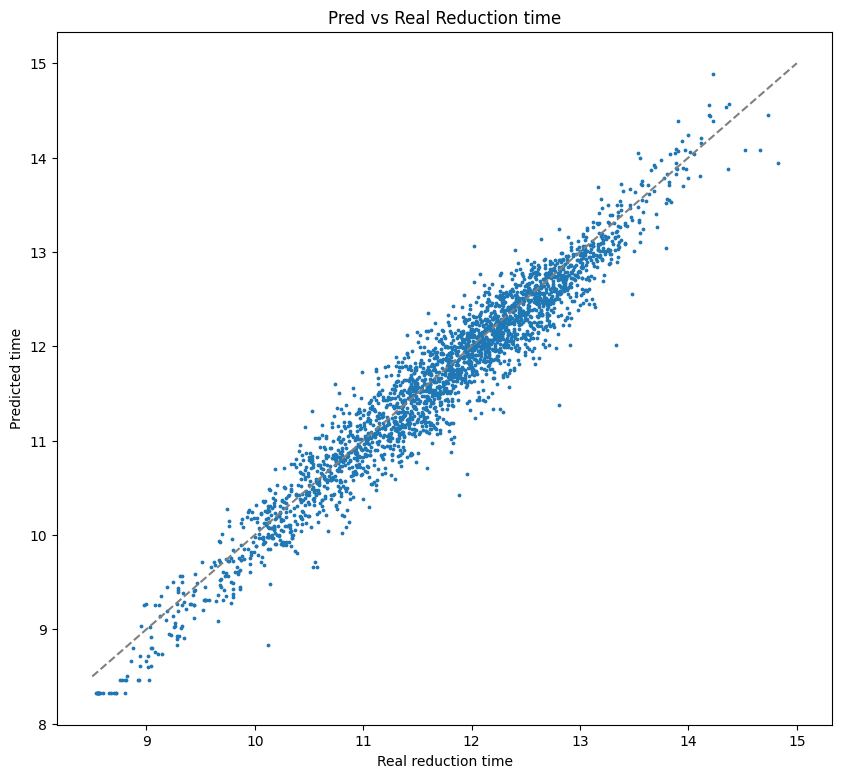

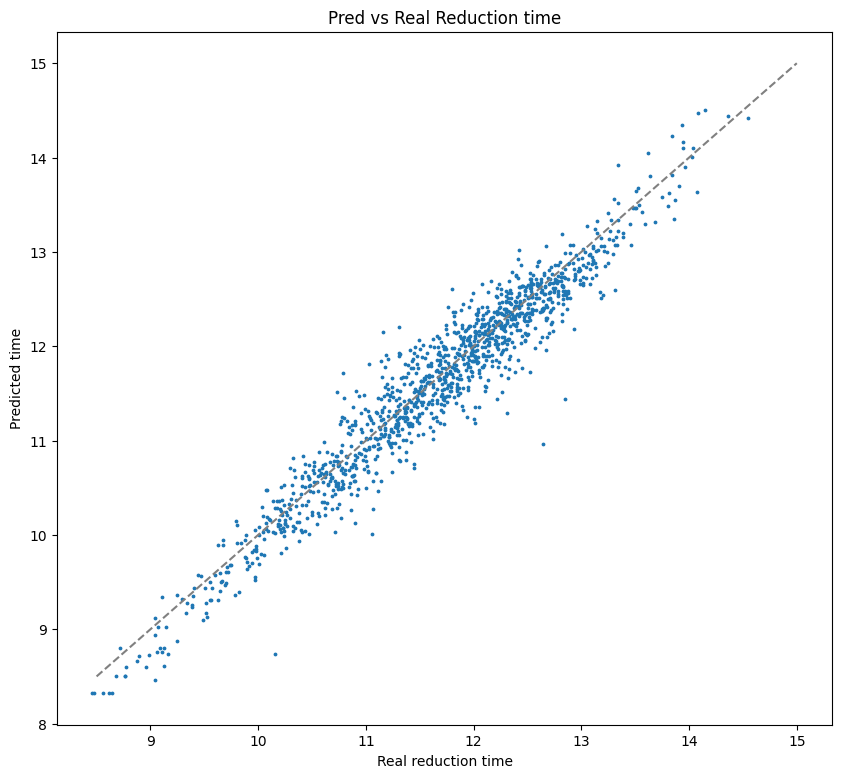

In [15]:
draw_pred_scatter(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_scatter(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [16]:
def draw_pred_lines_scatter(y_pred, y_real):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    plt.plot(range(len(drawing_df["Real"])), drawing_df["Real"], label="Real", c=colors[1])
    plt.scatter(range(len(drawing_df["Pred"])), drawing_df["Pred"], label="Pred", s=3, c=colors[0])

    plt.xlabel("No")
    plt.ylabel("Step Time")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

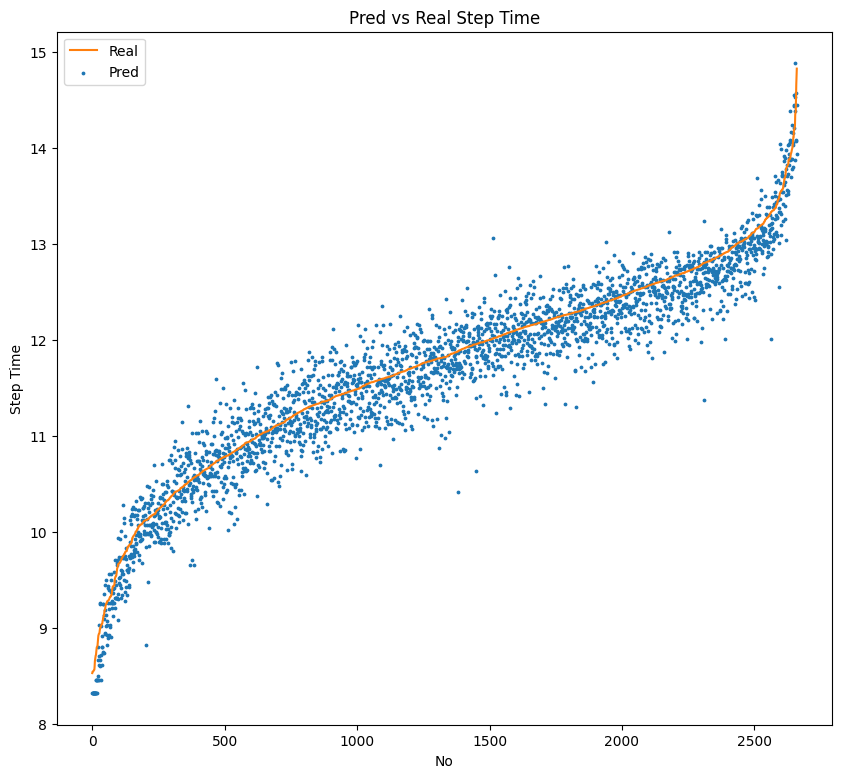

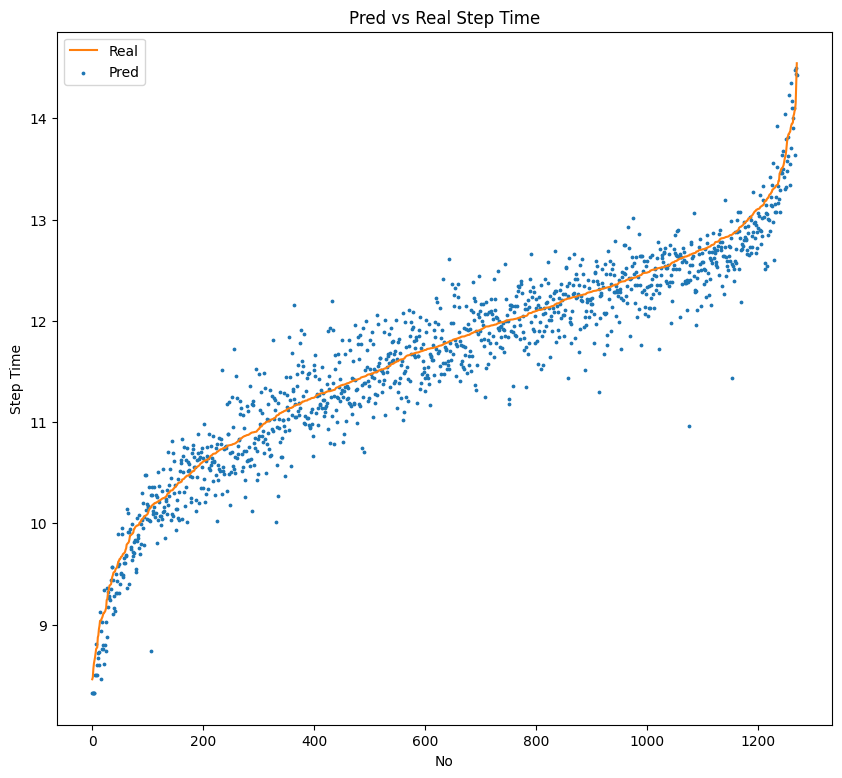

In [17]:
draw_pred_lines_scatter(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines_scatter(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [19]:
mse_train = mean_squared_error(y_train["steps_time"].to_list(), list(y_train_pred[:, -1]))
print("Train {Mean Squared Error}:", mse_train)

mse_test = mean_squared_error(y_test["steps_time"].to_list(), list(y_test_pred[:, -1]))
print("Test {Mean Squared Error}:", mse_test)
mae_train = mean_absolute_error(y_train["steps_time"].to_list(), list(y_train_pred[:, -1]))
print("Train {Mean Absolute Error}:", mae_train)

mae_test = mean_absolute_error(y_test["steps_time"].to_list(), list(y_test_pred[:, -1]))
print("Test {Mean Absolute Error}:", mae_test)


def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true_fix = np.array([y_ for y_ in y_true])
    percentage_errors = np.abs((y_true - y_pred) / y_true_fix) * 100
    mape = np.mean(percentage_errors)
    return mape


mape_train = mean_absolute_percentage_error(y_train["steps_time"].to_list(), list(y_train_pred[:, -1]))
print("Train {Mean Absolute Percentage Error}:", mape_train)

mape_test = mean_absolute_percentage_error(y_test["steps_time"].to_list(), list(y_test_pred[:, -1]))
print("Test {Mean Absolute Percentage Error}:", mape_test)

Train {Mean Squared Error}: 0.0766408832065915
Test {Mean Squared Error}: 0.07862648671539749
Train {Mean Absolute Error}: 0.21418279767791504
Test {Mean Absolute Error}: 0.21463573996748256
Train {Mean Absolute Percentage Error}: 1.8463770739622454
Test {Mean Absolute Percentage Error}: 1.8562154659669925
